# Construction Project Overrun Prediction - Model Training

This notebook trains and evaluates binary classification models to predict next-day time and cost overruns.

**Data Aggregation:** Daily (aligned with construction management practices)

**Models:**
- Logistic Regression (interpretable baseline)
- XGBoost (gradient boosting performance)
- **Voting Ensemble** (LR + RF + XGBoost with soft voting)
- **Stacking Ensemble** (LR + RF + XGBoost with meta-learner)

**Key Considerations:**
- Class imbalance handled with `class_weight='balanced'` and `scale_pos_weight`
- Ensemble methods reduce variance and improve robustness on small datasets
- Evaluation focused on AUC, Precision, Recall (not just accuracy)
- SHAP analysis for explainability

## 1. Setup & Imports

In [83]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

# Explainability
import shap

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)

print("✅ All libraries imported successfully!")
print(f"Random seed: {RANDOM_SEED}")

✅ All libraries imported successfully!
Random seed: 15


## 2. Load Prepared Datasets

Load pre-processed datasets from pickle file. These datasets are generated by running `EDA_corr.ipynb` which saves them to `prepared_data/modeling_datasets.pkl`.

**To generate the datasets:**
1. Open and run `EDA_corr.ipynb` (all cells)
2. The notebook will save 14 datasets to `prepared_data/modeling_datasets.pkl`
3. Then come back here and run this notebook

In [84]:
import pickle
import os

print("=" * 80)
print("LOADING PREPARED DATASETS")
print("=" * 80)

# Path to the saved datasets
data_path = 'prepared_data/modeling_datasets.pkl'

# Check if file exists
if not os.path.exists(data_path):
    print(f"\n❌ Dataset file not found: {data_path}")
    print("\nPlease run EDA_corr.ipynb first to generate the datasets.")
    print("The notebook will save datasets to 'prepared_data/modeling_datasets.pkl'")
    raise FileNotFoundError(f"Dataset file not found: {data_path}")

# Load all datasets
print(f"\nLoading from: {data_path}")
with open(data_path, 'rb') as f:
    datasets = pickle.load(f)

# Unpack datasets
X_train_time = datasets['X_train_time']
X_val_time = datasets['X_val_time']
X_test_time = datasets['X_test_time']
y_train_time = datasets['y_train_time']
y_val_time = datasets['y_val_time']
y_test_time = datasets['y_test_time']

X_train_cost = datasets['X_train_cost']
X_val_cost = datasets['X_val_cost']
X_test_cost = datasets['X_test_cost']
y_train_cost = datasets['y_train_cost']
y_val_cost = datasets['y_val_cost']
y_test_cost = datasets['y_test_cost']

top_15_time_features = datasets['top_10_time_features']
top_15_cost_features = datasets['top_10_cost_features']

print("\n✅ All datasets loaded successfully!")
print("\n📊 TIME MODEL:")
print(f"  X_train_time: {X_train_time.shape}")
print(f"  X_val_time:   {X_val_time.shape}")
print(f"  X_test_time:  {X_test_time.shape}")

print("\n💰 COST MODEL:")
print(f"  X_train_cost: {X_train_cost.shape}")
print(f"  X_val_cost:   {X_val_cost.shape}")
print(f"  X_test_cost:  {X_test_cost.shape}")

print("\n" + "=" * 80)
print("✅ READY FOR MODEL TRAINING!")
print("=" * 80)

LOADING PREPARED DATASETS

Loading from: prepared_data/modeling_datasets.pkl

✅ All datasets loaded successfully!

📊 TIME MODEL:
  X_train_time: (23, 10)
  X_val_time:   (5, 10)
  X_test_time:  (6, 10)

💰 COST MODEL:
  X_train_cost: (23, 10)
  X_val_cost:   (5, 10)
  X_test_cost:  (6, 10)

✅ READY FOR MODEL TRAINING!


## 3. Feature Scaling

Standardize features for Logistic Regression (XGBoost doesn't strictly need it, but it doesn't hurt)

In [85]:
print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Initialize scalers (separate for time and cost models)
scaler_time = StandardScaler()
scaler_cost = StandardScaler()

# TIME MODEL - Fit on train, transform all sets
X_train_time_scaled = scaler_time.fit_transform(X_train_time)
X_val_time_scaled = scaler_time.transform(X_val_time)
X_test_time_scaled = scaler_time.transform(X_test_time)

print("\n📊 TIME MODEL:")
print(f"  Feature mean (after scaling): {X_train_time_scaled.mean():.6f}")
print(f"  Feature std (after scaling):  {X_train_time_scaled.std():.6f}")

# COST MODEL - Fit on train, transform all sets
X_train_cost_scaled = scaler_cost.fit_transform(X_train_cost)
X_val_cost_scaled = scaler_cost.transform(X_val_cost)
X_test_cost_scaled = scaler_cost.transform(X_test_cost)

print("\n💰 COST MODEL:")
print(f"  Feature mean (after scaling): {X_train_cost_scaled.mean():.6f}")
print(f"  Feature std (after scaling):  {X_train_cost_scaled.std():.6f}")

print("\n✅ Feature scaling complete!")
print("=" * 80)

FEATURE SCALING

📊 TIME MODEL:
  Feature mean (after scaling): -0.000000
  Feature std (after scaling):  1.000000

💰 COST MODEL:
  Feature mean (after scaling): 0.000000
  Feature std (after scaling):  1.000000

✅ Feature scaling complete!


## 4. Model Training - TIME Overrun Prediction

We'll train both Logistic Regression and XGBoost for the TIME overrun model.

### 4.1 Logistic Regression (TIME)

In [86]:
print("=" * 80)
print("TRAINING: Logistic Regression - TIME OVERRUN MODEL")
print("=" * 80)

# Calculate class imbalance for reference
neg_count_time = (y_train_time == 0).sum()
pos_count_time = (y_train_time == 1).sum()
imbalance_ratio_time = pos_count_time / neg_count_time

print(f"\nClass distribution in training set:")
print(f"  Class 0 (No overrun): {neg_count_time}")
print(f"  Class 1 (Overrun):    {pos_count_time}")
print(f"  Imbalance ratio: {imbalance_ratio_time:.2f} (positive/negative)")

# Initialize Logistic Regression with balanced class weights
lr_time = LogisticRegression(
    class_weight='balanced',  # Handles class imbalance
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='lbfgs'
)

# Train
print("\nTraining...")
lr_time.fit(X_train_time_scaled, y_train_time)

# Predictions
y_train_pred_lr_time = lr_time.predict(X_train_time_scaled)
y_val_pred_lr_time = lr_time.predict(X_val_time_scaled)
y_test_pred_lr_time = lr_time.predict(X_test_time_scaled)

# Prediction probabilities (for AUC)
y_train_proba_lr_time = lr_time.predict_proba(X_train_time_scaled)[:, 1]
y_val_proba_lr_time = lr_time.predict_proba(X_val_time_scaled)[:, 1]
y_test_proba_lr_time = lr_time.predict_proba(X_test_time_scaled)[:, 1]

print("✅ Training complete!")
print("=" * 80)

TRAINING: Logistic Regression - TIME OVERRUN MODEL

Class distribution in training set:
  Class 0 (No overrun): 8
  Class 1 (Overrun):    15
  Imbalance ratio: 1.88 (positive/negative)

Training...
✅ Training complete!


### 4.2 XGBoost (TIME)

In [87]:
print("=" * 80)
print("TRAINING: XGBoost - TIME OVERRUN MODEL")
print("=" * 80)

# Calculate scale_pos_weight for XGBoost
scale_pos_weight_time = neg_count_time / pos_count_time
print(f"\nscale_pos_weight: {scale_pos_weight_time:.2f}")

# Initialize XGBoost with class imbalance handling
xgb_time = XGBClassifier(
    scale_pos_weight=scale_pos_weight_time,  # Handles class imbalance
    random_state=RANDOM_SEED,
    n_estimators=100,
    max_depth=3,  # Keep shallow for small dataset
    learning_rate=0.1,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train
print("\nTraining...")
xgb_time.fit(X_train_time_scaled, y_train_time)

# Predictions
y_train_pred_xgb_time = xgb_time.predict(X_train_time_scaled)
y_val_pred_xgb_time = xgb_time.predict(X_val_time_scaled)
y_test_pred_xgb_time = xgb_time.predict(X_test_time_scaled)

# Prediction probabilities
y_train_proba_xgb_time = xgb_time.predict_proba(X_train_time_scaled)[:, 1]
y_val_proba_xgb_time = xgb_time.predict_proba(X_val_time_scaled)[:, 1]
y_test_proba_xgb_time = xgb_time.predict_proba(X_test_time_scaled)[:, 1]

print("✅ Training complete!")
print("=" * 80)

TRAINING: XGBoost - TIME OVERRUN MODEL

scale_pos_weight: 0.53

Training...


✅ Training complete!


## 5. Model Training - COST Overrun Prediction

### 5.1 Logistic Regression (COST)

In [88]:
print("=" * 80)
print("TRAINING: Logistic Regression - COST OVERRUN MODEL")
print("=" * 80)

# Calculate class imbalance
neg_count_cost = (y_train_cost == 0).sum()
pos_count_cost = (y_train_cost == 1).sum()
imbalance_ratio_cost = pos_count_cost / neg_count_cost

print(f"\nClass distribution in training set:")
print(f"  Class 0 (No overrun): {neg_count_cost}")
print(f"  Class 1 (Overrun):    {pos_count_cost}")
print(f"  Imbalance ratio: {imbalance_ratio_cost:.2f}")

# Initialize and train
lr_cost = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='lbfgs'
)

print("\nTraining...")
lr_cost.fit(X_train_cost_scaled, y_train_cost)

# Predictions
y_train_pred_lr_cost = lr_cost.predict(X_train_cost_scaled)
y_val_pred_lr_cost = lr_cost.predict(X_val_cost_scaled)
y_test_pred_lr_cost = lr_cost.predict(X_test_cost_scaled)

y_train_proba_lr_cost = lr_cost.predict_proba(X_train_cost_scaled)[:, 1]
y_val_proba_lr_cost = lr_cost.predict_proba(X_val_cost_scaled)[:, 1]
y_test_proba_lr_cost = lr_cost.predict_proba(X_test_cost_scaled)[:, 1]

print("✅ Training complete!")
print("=" * 80)

TRAINING: Logistic Regression - COST OVERRUN MODEL

Class distribution in training set:
  Class 0 (No overrun): 9
  Class 1 (Overrun):    14
  Imbalance ratio: 1.56

Training...
✅ Training complete!


### 5.2 XGBoost (COST)

In [89]:
print("=" * 80)
print("TRAINING: XGBoost - COST OVERRUN MODEL")
print("=" * 80)

# Calculate scale_pos_weight
scale_pos_weight_cost = neg_count_cost / pos_count_cost
print(f"\nscale_pos_weight: {scale_pos_weight_cost:.2f}")

# Initialize and train
xgb_cost = XGBClassifier(
    scale_pos_weight=scale_pos_weight_cost,
    random_state=RANDOM_SEED,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining...")
xgb_cost.fit(X_train_cost_scaled, y_train_cost)

# Predictions
y_train_pred_xgb_cost = xgb_cost.predict(X_train_cost_scaled)
y_val_pred_xgb_cost = xgb_cost.predict(X_val_cost_scaled)
y_test_pred_xgb_cost = xgb_cost.predict(X_test_cost_scaled)

y_train_proba_xgb_cost = xgb_cost.predict_proba(X_train_cost_scaled)[:, 1]
y_val_proba_xgb_cost = xgb_cost.predict_proba(X_val_cost_scaled)[:, 1]
y_test_proba_xgb_cost = xgb_cost.predict_proba(X_test_cost_scaled)[:, 1]

print("✅ Training complete!")
print("=" * 80)

TRAINING: XGBoost - COST OVERRUN MODEL

scale_pos_weight: 0.64

Training...


✅ Training complete!


## 5.3 Ensemble Methods

Combine multiple models for potentially better performance. Ensemble methods work well with small datasets by reducing variance.

### 5.3.1 Voting Classifier - TIME Model

In [90]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

print("=" * 80)
print("TRAINING: Voting Classifier (Soft Voting) - TIME OVERRUN MODEL")
print("=" * 80)

# Create base models
lr_voting_time = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000
)

rf_voting_time = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,  # Shallow trees to avoid overfitting
    class_weight='balanced',
    random_state=RANDOM_SEED
)

xgb_voting_time = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio_time,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

# Create voting classifier (soft voting uses probability averaging)
voting_time = VotingClassifier(
    estimators=[
        ('lr', lr_voting_time),
        ('rf', rf_voting_time),
        ('xgb', xgb_voting_time)
    ],
    voting='soft'  # Average probabilities
)

print("\nEnsemble members:")
print("  1. Logistic Regression (interpretable baseline)")
print("  2. Random Forest (captures non-linear patterns)")
print("  3. XGBoost (gradient boosting)")
print("  Voting strategy: Soft (probability averaging)")

print("\nTraining...")
voting_time.fit(X_train_time_scaled, y_train_time)

# Predictions
y_train_pred_voting_time = voting_time.predict(X_train_time_scaled)
y_val_pred_voting_time = voting_time.predict(X_val_time_scaled)
y_test_pred_voting_time = voting_time.predict(X_test_time_scaled)

y_train_proba_voting_time = voting_time.predict_proba(X_train_time_scaled)[:, 1]
y_val_proba_voting_time = voting_time.predict_proba(X_val_time_scaled)[:, 1]
y_test_proba_voting_time = voting_time.predict_proba(X_test_time_scaled)[:, 1]

print("✅ Voting Classifier trained!")
print("=" * 80)

TRAINING: Voting Classifier (Soft Voting) - TIME OVERRUN MODEL

Ensemble members:
  1. Logistic Regression (interpretable baseline)
  2. Random Forest (captures non-linear patterns)
  3. XGBoost (gradient boosting)
  Voting strategy: Soft (probability averaging)

Training...
✅ Voting Classifier trained!
✅ Voting Classifier trained!


### 5.3.2 Voting Classifier - COST Model

In [91]:
print("=" * 80)
print("TRAINING: Voting Classifier (Soft Voting) - COST OVERRUN MODEL")
print("=" * 80)

# Create base models
lr_voting_cost = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000
)

rf_voting_cost = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    class_weight='balanced',
    random_state=RANDOM_SEED
)

xgb_voting_cost = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio_cost,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

# Create voting classifier
voting_cost = VotingClassifier(
    estimators=[
        ('lr', lr_voting_cost),
        ('rf', rf_voting_cost),
        ('xgb', xgb_voting_cost)
    ],
    voting='soft'
)

print("\nTraining...")
voting_cost.fit(X_train_cost_scaled, y_train_cost)

# Predictions
y_train_pred_voting_cost = voting_cost.predict(X_train_cost_scaled)
y_val_pred_voting_cost = voting_cost.predict(X_val_cost_scaled)
y_test_pred_voting_cost = voting_cost.predict(X_test_cost_scaled)

y_train_proba_voting_cost = voting_cost.predict_proba(X_train_cost_scaled)[:, 1]
y_val_proba_voting_cost = voting_cost.predict_proba(X_val_cost_scaled)[:, 1]
y_test_proba_voting_cost = voting_cost.predict_proba(X_test_cost_scaled)[:, 1]

print("✅ Voting Classifier trained!")
print("=" * 80)

TRAINING: Voting Classifier (Soft Voting) - COST OVERRUN MODEL

Training...
✅ Voting Classifier trained!
✅ Voting Classifier trained!


### 5.3.3 Stacking Classifier - TIME Model

Stacking uses a meta-learner to combine predictions from base models.

In [92]:
from sklearn.ensemble import StackingClassifier

print("=" * 80)
print("TRAINING: Stacking Classifier - TIME OVERRUN MODEL")
print("=" * 80)

# Base models
lr_stack_time = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000
)

rf_stack_time = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    class_weight='balanced',
    random_state=RANDOM_SEED
)

xgb_stack_time = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio_time,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

# Meta-learner (uses base model predictions as features)
meta_learner_time = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED)

# Create stacking classifier
stacking_time = StackingClassifier(
    estimators=[
        ('lr', lr_stack_time),
        ('rf', rf_stack_time),
        ('xgb', xgb_stack_time)
    ],
    final_estimator=meta_learner_time,
    cv=3  # 3-fold cross-validation for meta-features
)

print("\nBase models: LR, RF, XGBoost")
print("Meta-learner: Logistic Regression")
print("Cross-validation folds: 3")

print("\nTraining...")
stacking_time.fit(X_train_time_scaled, y_train_time)

# Predictions
y_train_pred_stacking_time = stacking_time.predict(X_train_time_scaled)
y_val_pred_stacking_time = stacking_time.predict(X_val_time_scaled)
y_test_pred_stacking_time = stacking_time.predict(X_test_time_scaled)

y_train_proba_stacking_time = stacking_time.predict_proba(X_train_time_scaled)[:, 1]
y_val_proba_stacking_time = stacking_time.predict_proba(X_val_time_scaled)[:, 1]
y_test_proba_stacking_time = stacking_time.predict_proba(X_test_time_scaled)[:, 1]

print("✅ Stacking Classifier trained!")
print("=" * 80)

TRAINING: Stacking Classifier - TIME OVERRUN MODEL

Base models: LR, RF, XGBoost
Meta-learner: Logistic Regression
Cross-validation folds: 3

Training...
✅ Stacking Classifier trained!
✅ Stacking Classifier trained!


### 5.3.4 Stacking Classifier - COST Model

In [93]:
print("=" * 80)
print("TRAINING: Stacking Classifier - COST OVERRUN MODEL")
print("=" * 80)

# Base models
lr_stack_cost = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_SEED,
    max_iter=1000
)

rf_stack_cost = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    class_weight='balanced',
    random_state=RANDOM_SEED
)

xgb_stack_cost = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio_cost,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

# Meta-learner
meta_learner_cost = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED)

# Create stacking classifier
stacking_cost = StackingClassifier(
    estimators=[
        ('lr', lr_stack_cost),
        ('rf', rf_stack_cost),
        ('xgb', xgb_stack_cost)
    ],
    final_estimator=meta_learner_cost,
    cv=3
)

print("\nTraining...")
stacking_cost.fit(X_train_cost_scaled, y_train_cost)

# Predictions
y_train_pred_stacking_cost = stacking_cost.predict(X_train_cost_scaled)
y_val_pred_stacking_cost = stacking_cost.predict(X_val_cost_scaled)
y_test_pred_stacking_cost = stacking_cost.predict(X_test_cost_scaled)

y_train_proba_stacking_cost = stacking_cost.predict_proba(X_train_cost_scaled)[:, 1]
y_val_proba_stacking_cost = stacking_cost.predict_proba(X_val_cost_scaled)[:, 1]
y_test_proba_stacking_cost = stacking_cost.predict_proba(X_test_cost_scaled)[:, 1]

print("✅ Stacking Classifier trained!")
print("=" * 80)

TRAINING: Stacking Classifier - COST OVERRUN MODEL

Training...
✅ Stacking Classifier trained!
✅ Stacking Classifier trained!


## 6. Model Evaluation

Comprehensive evaluation using multiple metrics (not just accuracy!)

In [94]:
def evaluate_model(y_true, y_pred, y_proba, model_name, dataset_name):
    """Compute comprehensive evaluation metrics"""
    
    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else np.nan
    }
    
    return metrics

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


### 6.1 TIME Model Evaluation

In [95]:
print("=" * 80)
print("EVALUATION: TIME OVERRUN MODELS")
print("=" * 80)

# Collect all metrics
results_time = []

# Logistic Regression
results_time.append(evaluate_model(y_train_time, y_train_pred_lr_time, y_train_proba_lr_time, 'Logistic Regression', 'Train'))
results_time.append(evaluate_model(y_val_time, y_val_pred_lr_time, y_val_proba_lr_time, 'Logistic Regression', 'Val'))
results_time.append(evaluate_model(y_test_time, y_test_pred_lr_time, y_test_proba_lr_time, 'Logistic Regression', 'Test'))

# XGBoost
results_time.append(evaluate_model(y_train_time, y_train_pred_xgb_time, y_train_proba_xgb_time, 'XGBoost', 'Train'))
results_time.append(evaluate_model(y_val_time, y_val_pred_xgb_time, y_val_proba_xgb_time, 'XGBoost', 'Val'))
results_time.append(evaluate_model(y_test_time, y_test_pred_xgb_time, y_test_proba_xgb_time, 'XGBoost', 'Test'))

# Voting Classifier
results_time.append(evaluate_model(y_train_time, y_train_pred_voting_time, y_train_proba_voting_time, 'Voting Ensemble', 'Train'))
results_time.append(evaluate_model(y_val_time, y_val_pred_voting_time, y_val_proba_voting_time, 'Voting Ensemble', 'Val'))
results_time.append(evaluate_model(y_test_time, y_test_pred_voting_time, y_test_proba_voting_time, 'Voting Ensemble', 'Test'))

# Stacking Classifier
results_time.append(evaluate_model(y_train_time, y_train_pred_stacking_time, y_train_proba_stacking_time, 'Stacking Ensemble', 'Train'))
results_time.append(evaluate_model(y_val_time, y_val_pred_stacking_time, y_val_proba_stacking_time, 'Stacking Ensemble', 'Val'))
results_time.append(evaluate_model(y_test_time, y_test_pred_stacking_time, y_test_proba_stacking_time, 'Stacking Ensemble', 'Test'))

# Create DataFrame
df_results_time = pd.DataFrame(results_time)

# Display
print("\n📊 TIME OVERRUN MODEL - PERFORMANCE METRICS")
print("-" * 80)
print(df_results_time.to_string(index=False))
print("\n" + "=" * 80)

EVALUATION: TIME OVERRUN MODELS

📊 TIME OVERRUN MODEL - PERFORMANCE METRICS
--------------------------------------------------------------------------------
              Model Dataset  Accuracy  Precision   Recall       F1  AUC-ROC
Logistic Regression   Train  0.782609   0.916667 0.733333 0.814815 0.791667
Logistic Regression     Val  0.200000   0.333333 0.333333 0.333333 0.000000
Logistic Regression    Test  0.500000   0.666667 0.500000 0.571429 0.375000
            XGBoost   Train  0.956522   1.000000 0.933333 0.965517 0.987500
            XGBoost     Val  0.200000   0.000000 0.000000 0.000000 0.000000
            XGBoost    Test  0.166667   0.333333 0.250000 0.285714 0.125000
    Voting Ensemble   Train  0.956522   0.937500 1.000000 0.967742 0.991667
    Voting Ensemble     Val  0.400000   0.500000 0.666667 0.571429 0.000000
    Voting Ensemble    Test  0.166667   0.333333 0.250000 0.285714 0.125000
  Stacking Ensemble   Train  0.347826   0.500000 0.333333 0.400000 0.266667
  Stack

### 6.2 COST Model Evaluation

In [96]:
print("=" * 80)
print("EVALUATION: COST OVERRUN MODELS")
print("=" * 80)

# Collect all metrics
results_cost = []

# Logistic Regression
results_cost.append(evaluate_model(y_train_cost, y_train_pred_lr_cost, y_train_proba_lr_cost, 'Logistic Regression', 'Train'))
results_cost.append(evaluate_model(y_val_cost, y_val_pred_lr_cost, y_val_proba_lr_cost, 'Logistic Regression', 'Val'))
results_cost.append(evaluate_model(y_test_cost, y_test_pred_lr_cost, y_test_proba_lr_cost, 'Logistic Regression', 'Test'))

# XGBoost
results_cost.append(evaluate_model(y_train_cost, y_train_pred_xgb_cost, y_train_proba_xgb_cost, 'XGBoost', 'Train'))
results_cost.append(evaluate_model(y_val_cost, y_val_pred_xgb_cost, y_val_proba_xgb_cost, 'XGBoost', 'Val'))
results_cost.append(evaluate_model(y_test_cost, y_test_pred_xgb_cost, y_test_proba_xgb_cost, 'XGBoost', 'Test'))

# Voting Classifier
results_cost.append(evaluate_model(y_train_cost, y_train_pred_voting_cost, y_train_proba_voting_cost, 'Voting Ensemble', 'Train'))
results_cost.append(evaluate_model(y_val_cost, y_val_pred_voting_cost, y_val_proba_voting_cost, 'Voting Ensemble', 'Val'))
results_cost.append(evaluate_model(y_test_cost, y_test_pred_voting_cost, y_test_proba_voting_cost, 'Voting Ensemble', 'Test'))

# Stacking Classifier
results_cost.append(evaluate_model(y_train_cost, y_train_pred_stacking_cost, y_train_proba_stacking_cost, 'Stacking Ensemble', 'Train'))
results_cost.append(evaluate_model(y_val_cost, y_val_pred_stacking_cost, y_val_proba_stacking_cost, 'Stacking Ensemble', 'Val'))
results_cost.append(evaluate_model(y_test_cost, y_test_pred_stacking_cost, y_test_proba_stacking_cost, 'Stacking Ensemble', 'Test'))

# Create DataFrame
df_results_cost = pd.DataFrame(results_cost)

# Display
print("\n💰 COST OVERRUN MODEL - PERFORMANCE METRICS")
print("-" * 80)
print(df_results_cost.to_string(index=False))
print("\n" + "=" * 80)

EVALUATION: COST OVERRUN MODELS

💰 COST OVERRUN MODEL - PERFORMANCE METRICS
--------------------------------------------------------------------------------
              Model Dataset  Accuracy  Precision   Recall       F1  AUC-ROC
Logistic Regression   Train  0.608696   0.857143 0.428571 0.571429 0.730159
Logistic Regression     Val  0.400000   0.000000 0.000000 0.000000 0.666667
Logistic Regression    Test  0.500000   0.000000 0.000000 0.000000 0.444444
            XGBoost   Train  0.956522   0.933333 1.000000 0.965517 0.996032
            XGBoost     Val  0.800000   1.000000 0.666667 0.800000 0.666667
            XGBoost    Test  0.333333   0.333333 0.333333 0.333333 0.333333
    Voting Ensemble   Train  1.000000   1.000000 1.000000 1.000000 1.000000
    Voting Ensemble     Val  0.800000   1.000000 0.666667 0.800000 0.833333
    Voting Ensemble    Test  0.333333   0.333333 0.333333 0.333333 0.333333
  Stacking Ensemble   Train  0.913043   1.000000 0.857143 0.923077 0.984127
  Stack

## 7. Confusion Matrices

Visualize prediction accuracy for each class

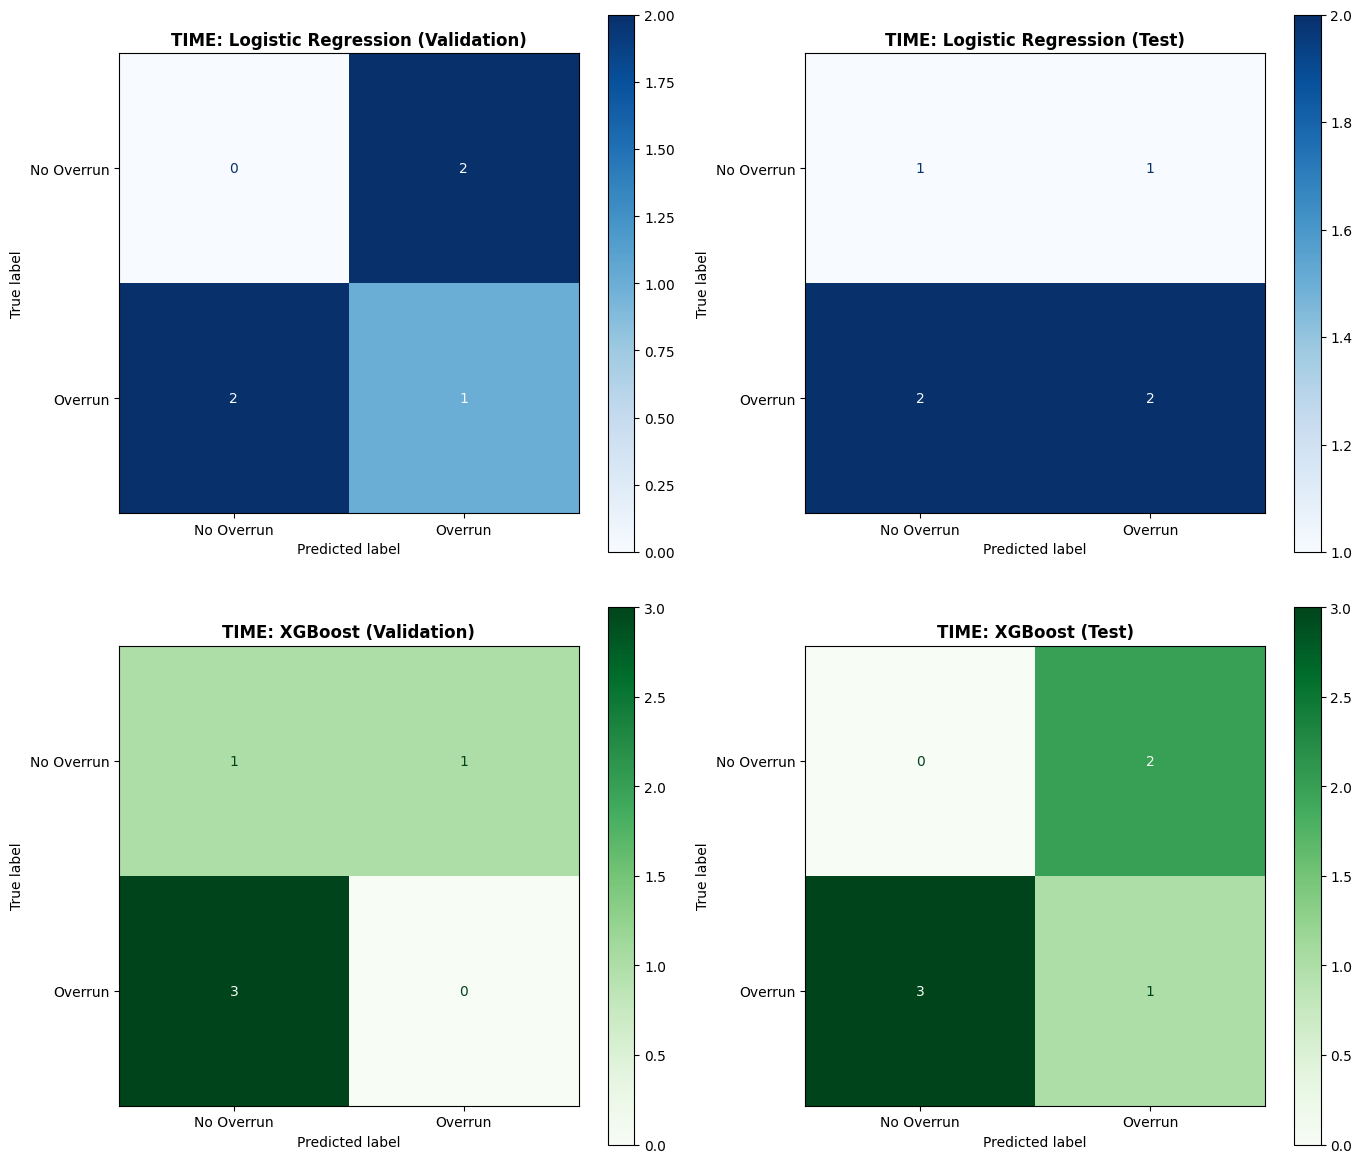

✅ TIME model confusion matrices saved!


In [97]:
# TIME MODEL - Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Logistic Regression - Val
cm_lr_time_val = confusion_matrix(y_val_time, y_val_pred_lr_time)
ConfusionMatrixDisplay(cm_lr_time_val, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('TIME: Logistic Regression (Validation)', fontweight='bold')

# Logistic Regression - Test
cm_lr_time_test = confusion_matrix(y_test_time, y_test_pred_lr_time)
ConfusionMatrixDisplay(cm_lr_time_test, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('TIME: Logistic Regression (Test)', fontweight='bold')

# XGBoost - Val
cm_xgb_time_val = confusion_matrix(y_val_time, y_val_pred_xgb_time)
ConfusionMatrixDisplay(cm_xgb_time_val, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[1, 0], cmap='Greens')
axes[1, 0].set_title('TIME: XGBoost (Validation)', fontweight='bold')

# XGBoost - Test
cm_xgb_time_test = confusion_matrix(y_test_time, y_test_pred_xgb_time)
ConfusionMatrixDisplay(cm_xgb_time_test, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[1, 1], cmap='Greens')
axes[1, 1].set_title('TIME: XGBoost (Test)', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ TIME model confusion matrices saved!")

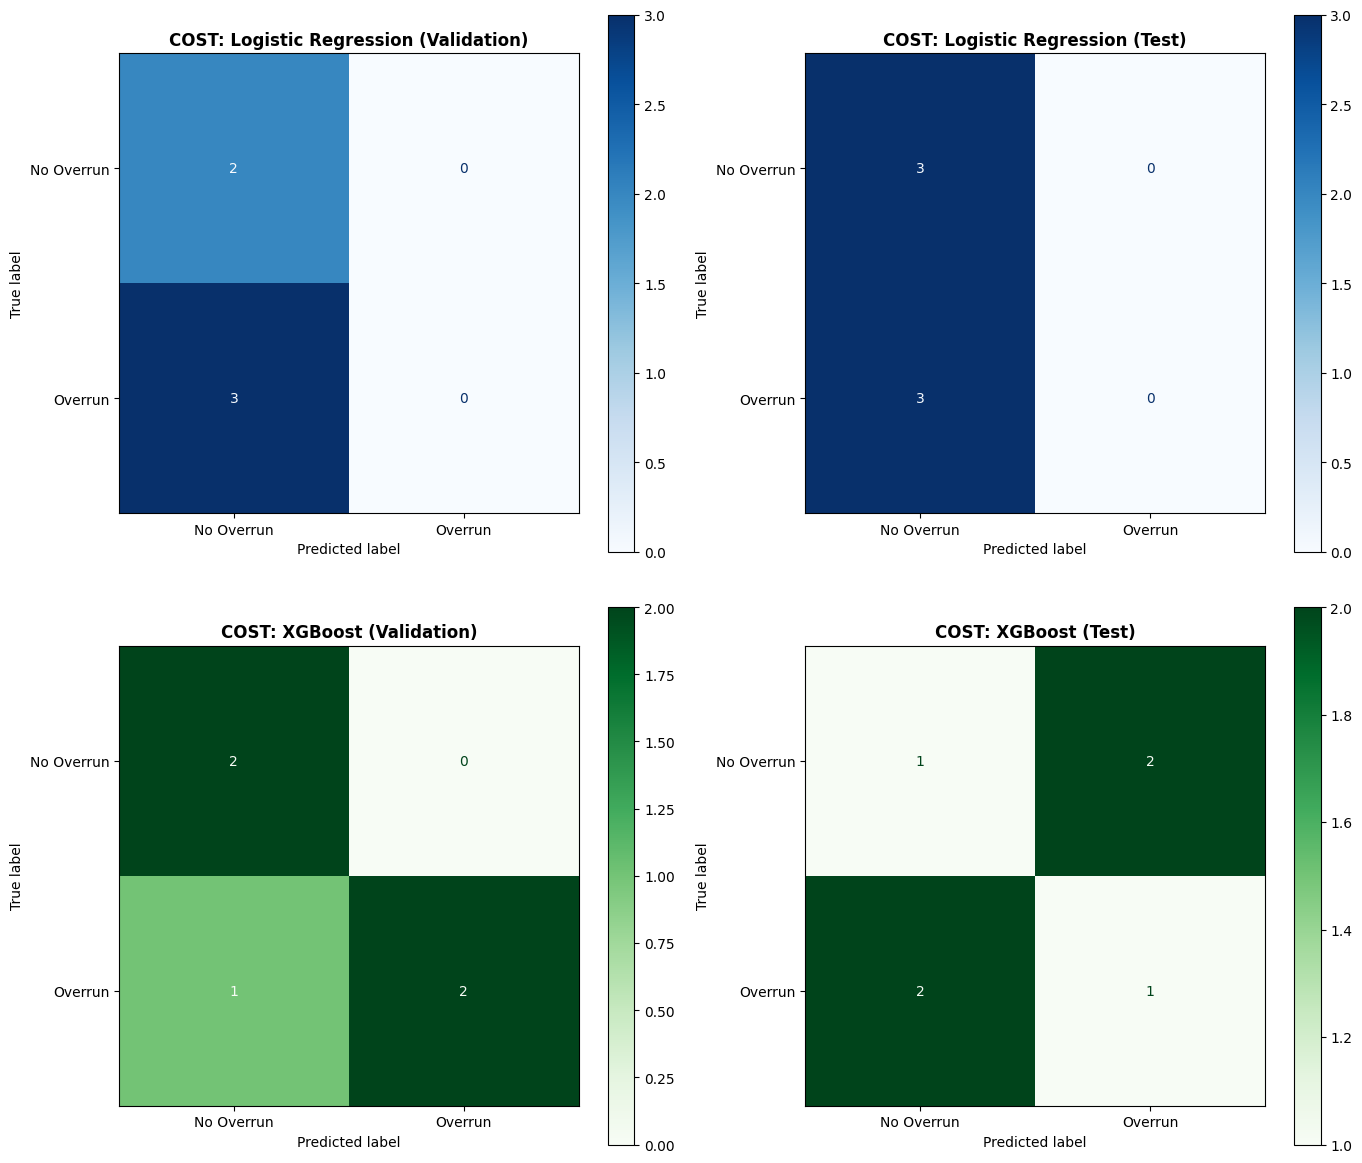

✅ COST model confusion matrices saved!


In [98]:
# COST MODEL - Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Logistic Regression - Val
cm_lr_cost_val = confusion_matrix(y_val_cost, y_val_pred_lr_cost)
ConfusionMatrixDisplay(cm_lr_cost_val, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('COST: Logistic Regression (Validation)', fontweight='bold')

# Logistic Regression - Test
cm_lr_cost_test = confusion_matrix(y_test_cost, y_test_pred_lr_cost)
ConfusionMatrixDisplay(cm_lr_cost_test, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('COST: Logistic Regression (Test)', fontweight='bold')

# XGBoost - Val
cm_xgb_cost_val = confusion_matrix(y_val_cost, y_val_pred_xgb_cost)
ConfusionMatrixDisplay(cm_xgb_cost_val, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[1, 0], cmap='Greens')
axes[1, 0].set_title('COST: XGBoost (Validation)', fontweight='bold')

# XGBoost - Test
cm_xgb_cost_test = confusion_matrix(y_test_cost, y_test_pred_xgb_cost)
ConfusionMatrixDisplay(cm_xgb_cost_test, display_labels=['No Overrun', 'Overrun']).plot(ax=axes[1, 1], cmap='Greens')
axes[1, 1].set_title('COST: XGBoost (Test)', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_cost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ COST model confusion matrices saved!")

## 8. ROC Curves

Compare model discrimination ability

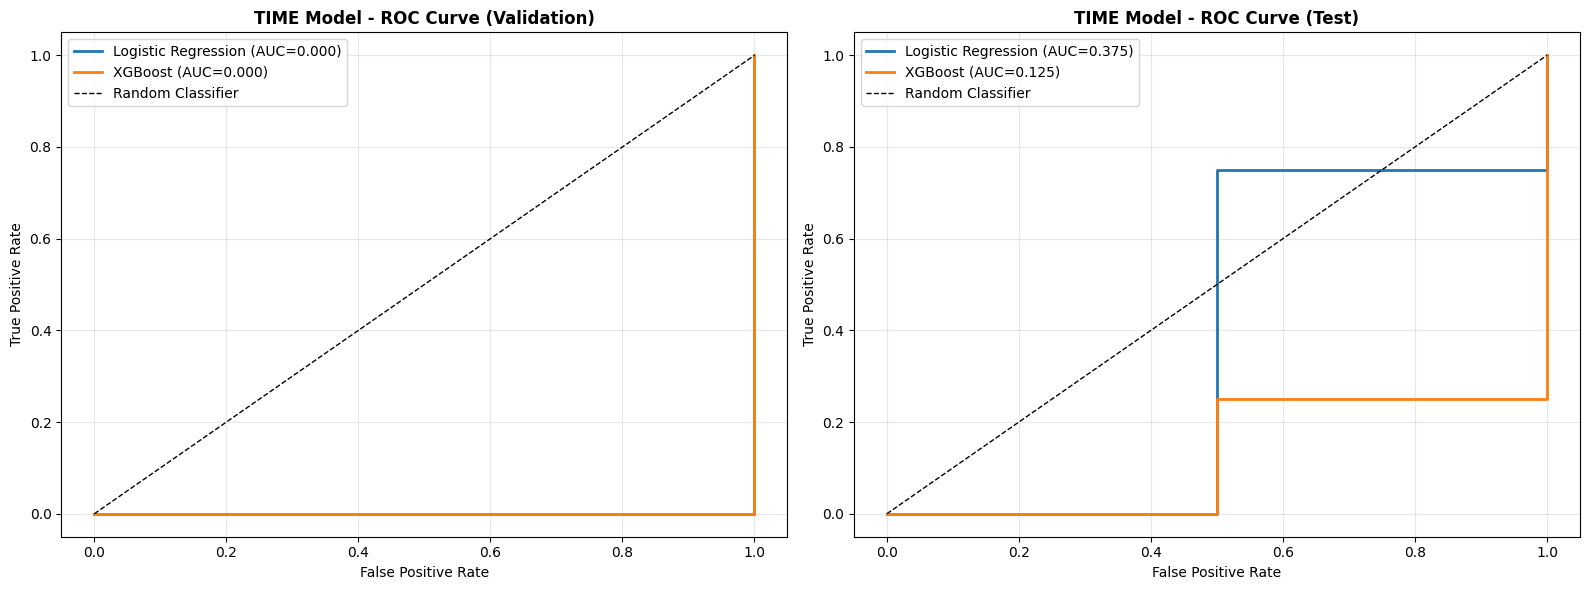

✅ TIME model ROC curves saved!


In [99]:
# TIME MODEL - ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation
if len(np.unique(y_val_time)) > 1:
    fpr_lr, tpr_lr, _ = roc_curve(y_val_time, y_val_proba_lr_time)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_val_time, y_val_proba_xgb_time)
    
    axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_val_time, y_val_proba_lr_time):.3f})', linewidth=2)
    axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_val_time, y_val_proba_xgb_time):.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('TIME Model - ROC Curve (Validation)', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Test
if len(np.unique(y_test_time)) > 1:
    fpr_lr, tpr_lr, _ = roc_curve(y_test_time, y_test_proba_lr_time)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_time, y_test_proba_xgb_time)
    
    axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test_time, y_test_proba_lr_time):.3f})', linewidth=2)
    axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test_time, y_test_proba_xgb_time):.3f})', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('TIME Model - ROC Curve (Test)', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ TIME model ROC curves saved!")

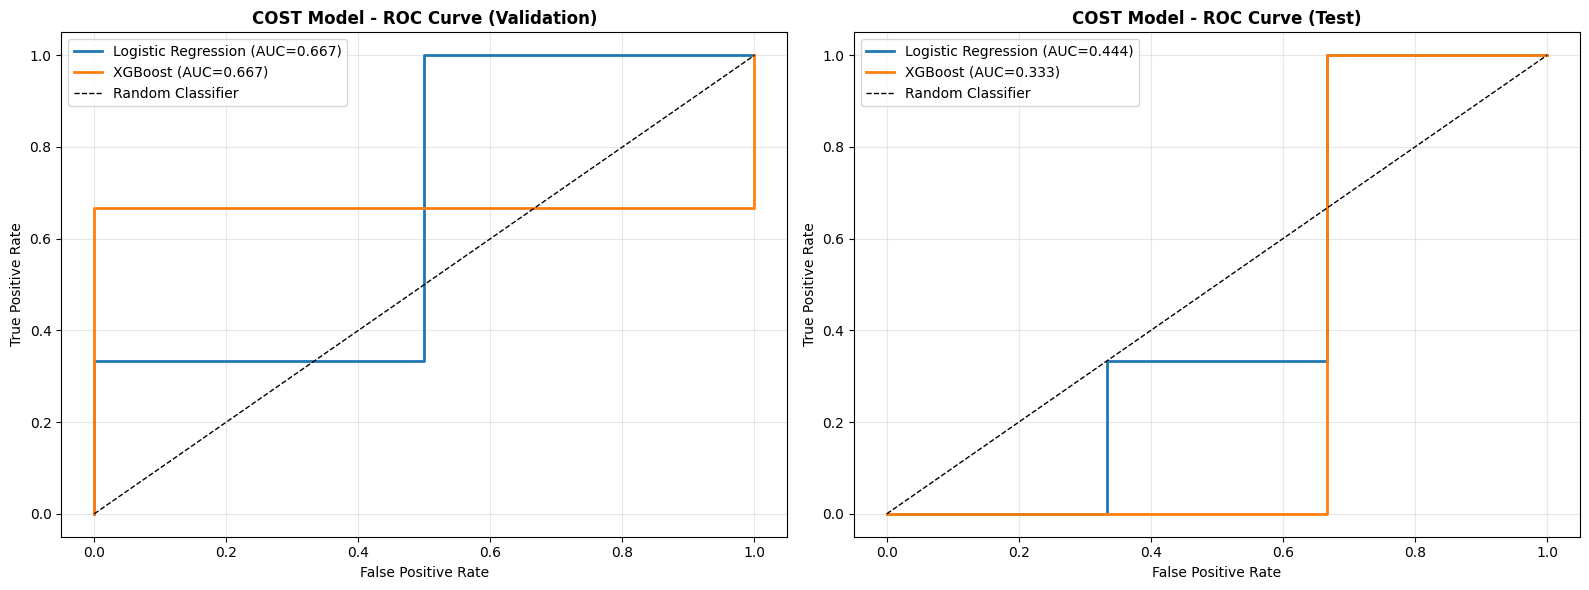

✅ COST model ROC curves saved!


In [100]:
# COST MODEL - ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation
if len(np.unique(y_val_cost)) > 1:
    fpr_lr, tpr_lr, _ = roc_curve(y_val_cost, y_val_proba_lr_cost)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_val_cost, y_val_proba_xgb_cost)
    
    axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_val_cost, y_val_proba_lr_cost):.3f})', linewidth=2)
    axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_val_cost, y_val_proba_xgb_cost):.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('COST Model - ROC Curve (Validation)', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Test
if len(np.unique(y_test_cost)) > 1:
    fpr_lr, tpr_lr, _ = roc_curve(y_test_cost, y_test_proba_lr_cost)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_cost, y_test_proba_xgb_cost)
    
    axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test_cost, y_test_proba_lr_cost):.3f})', linewidth=2)
    axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test_cost, y_test_proba_xgb_cost):.3f})', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('COST Model - ROC Curve (Test)', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_cost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ COST model ROC curves saved!")

## 9. Feature Importance Analysis

Understand which features drive predictions

### 9.1 Logistic Regression Coefficients

TIME MODEL - LOGISTIC REGRESSION FEATURE COEFFICIENTS
                        Feature  Coefficient
               safety_incidents    -0.818567
          safety_incidents_lag2    -0.595459
   material_shortage_alert_lag5     0.410483
   material_shortage_alert_lag2     0.240672
          safety_incidents_lag5     0.193849
              worker_count_lag2     0.169161
            material_usage_lag2     0.151449
equipment_utilization_rate_lag2     0.069080
                risk_score_lag2     0.068262
        energy_consumption_lag2     0.059037



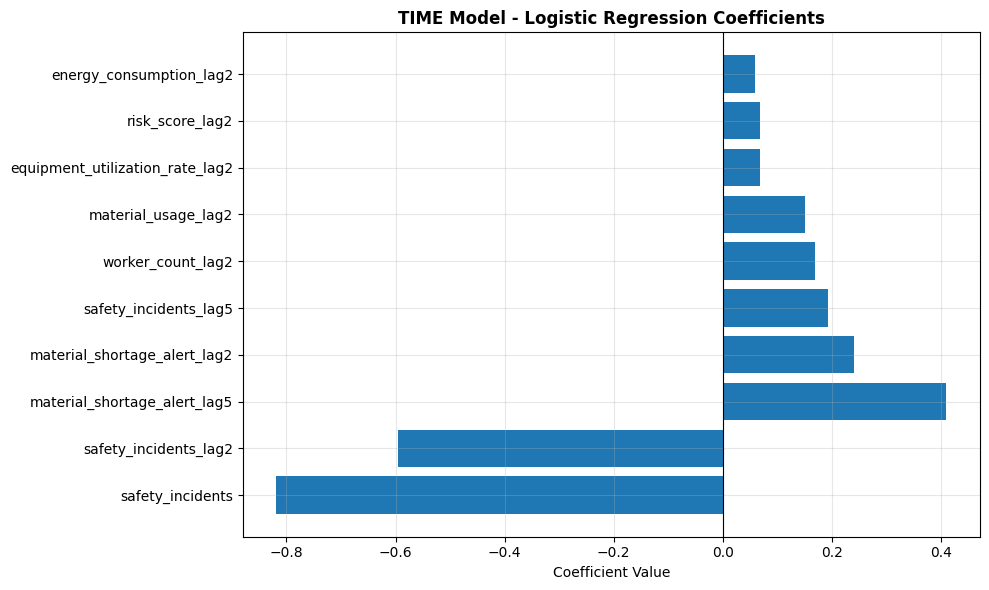

In [101]:
# TIME MODEL - Logistic Regression Coefficients
coef_time = pd.DataFrame({
    'Feature': top_15_time_features,
    'Coefficient': lr_time.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("=" * 80)
print("TIME MODEL - LOGISTIC REGRESSION FEATURE COEFFICIENTS")
print("=" * 80)
print(coef_time.to_string(index=False))
print("\n" + "=" * 80)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(coef_time['Feature'], coef_time['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('TIME Model - Logistic Regression Coefficients', fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lr_coefficients_time.png', dpi=300, bbox_inches='tight')
plt.show()

COST MODEL - LOGISTIC REGRESSION FEATURE COEFFICIENTS
                        Feature  Coefficient
                risk_score_lag5    -0.825967
   material_shortage_alert_lag7    -0.279754
          material_usage_change    -0.215997
           vibration_level_lag7    -0.095765
          safety_incidents_lag7     0.061538
              worker_count_lag7    -0.039027
equipment_utilization_rate_lag7    -0.032900
                risk_score_lag7     0.031925
        energy_consumption_lag7    -0.024285
            material_usage_lag7     0.000906



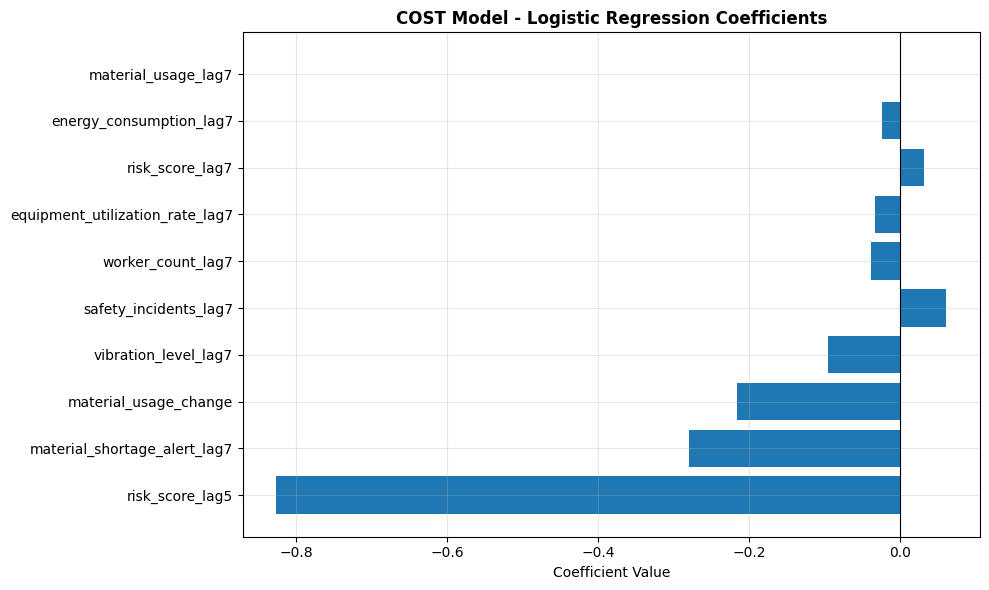

In [102]:
# COST MODEL - Logistic Regression Coefficients
coef_cost = pd.DataFrame({
    'Feature': top_15_cost_features,
    'Coefficient': lr_cost.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("=" * 80)
print("COST MODEL - LOGISTIC REGRESSION FEATURE COEFFICIENTS")
print("=" * 80)
print(coef_cost.to_string(index=False))
print("\n" + "=" * 80)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(coef_cost['Feature'], coef_cost['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('COST Model - Logistic Regression Coefficients', fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lr_coefficients_cost.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.2 XGBoost Feature Importance

TIME MODEL - XGBOOST FEATURE IMPORTANCE
                        Feature  Importance
equipment_utilization_rate_lag2    0.209502
               safety_incidents    0.193738
            material_usage_lag2    0.192324
              worker_count_lag2    0.147297
                risk_score_lag2    0.107305
   material_shortage_alert_lag2    0.102565
        energy_consumption_lag2    0.047269
          safety_incidents_lag2    0.000000
          safety_incidents_lag5    0.000000
   material_shortage_alert_lag5    0.000000



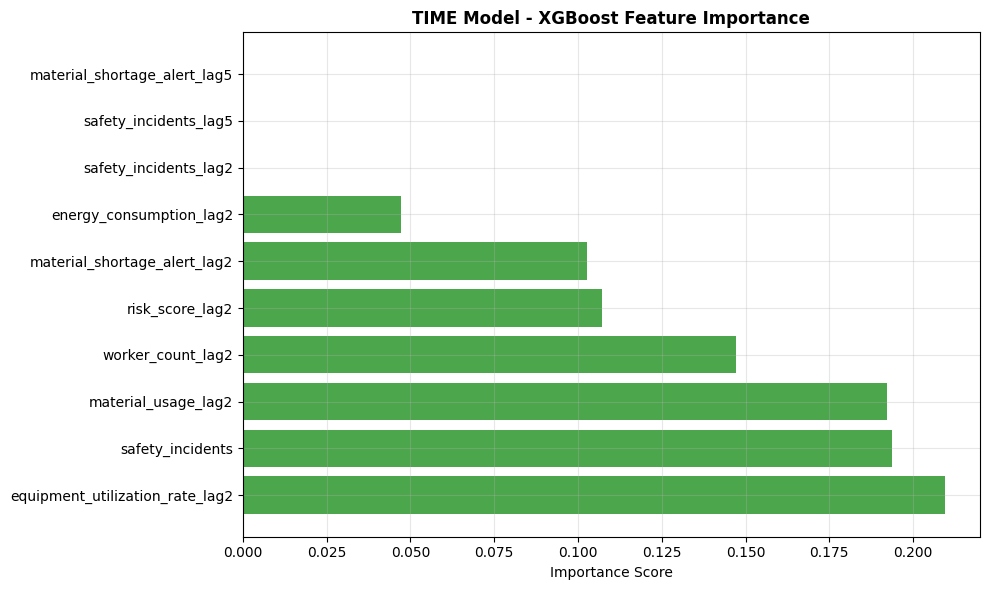

In [103]:
# TIME MODEL - XGBoost Feature Importance
importance_time = pd.DataFrame({
    'Feature': top_15_time_features,
    'Importance': xgb_time.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("TIME MODEL - XGBOOST FEATURE IMPORTANCE")
print("=" * 80)
print(importance_time.to_string(index=False))
print("\n" + "=" * 80)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_time['Feature'], importance_time['Importance'], color='green', alpha=0.7)
plt.xlabel('Importance Score')
plt.title('TIME Model - XGBoost Feature Importance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_importance_time.png', dpi=300, bbox_inches='tight')
plt.show()

COST MODEL - XGBOOST FEATURE IMPORTANCE
                        Feature  Importance
                risk_score_lag5    0.419465
equipment_utilization_rate_lag7    0.186911
   material_shortage_alert_lag7    0.119593
              worker_count_lag7    0.078641
           vibration_level_lag7    0.065211
          material_usage_change    0.064607
          safety_incidents_lag7    0.036210
                risk_score_lag7    0.029363
        energy_consumption_lag7    0.000000
            material_usage_lag7    0.000000



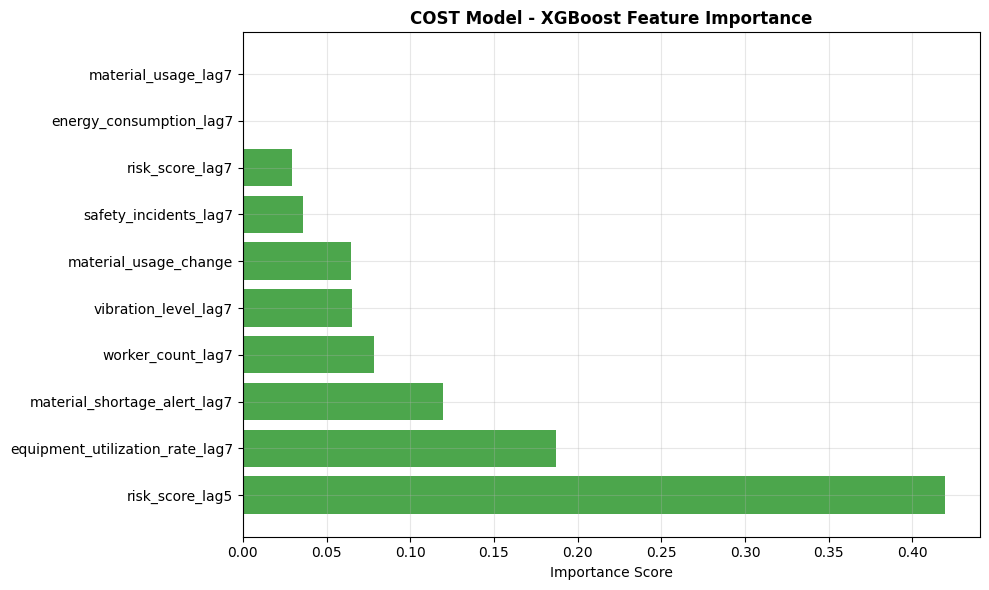

In [104]:
# COST MODEL - XGBoost Feature Importance
importance_cost = pd.DataFrame({
    'Feature': top_15_cost_features,
    'Importance': xgb_cost.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("COST MODEL - XGBOOST FEATURE IMPORTANCE")
print("=" * 80)
print(importance_cost.to_string(index=False))
print("\n" + "=" * 80)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_cost['Feature'], importance_cost['Importance'], color='green', alpha=0.7)
plt.xlabel('Importance Score')
plt.title('COST Model - XGBoost Feature Importance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_importance_cost.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. SHAP Analysis (Explainability)

Understand how features contribute to individual predictions

In [105]:
# Initialize SHAP explainer for XGBoost TIME model
print("Initializing SHAP explainer for TIME model...")
explainer_time = shap.TreeExplainer(xgb_time)
shap_values_time = explainer_time.shap_values(X_test_time_scaled)
print("✅ SHAP values computed for TIME model!")

Initializing SHAP explainer for TIME model...
✅ SHAP values computed for TIME model!


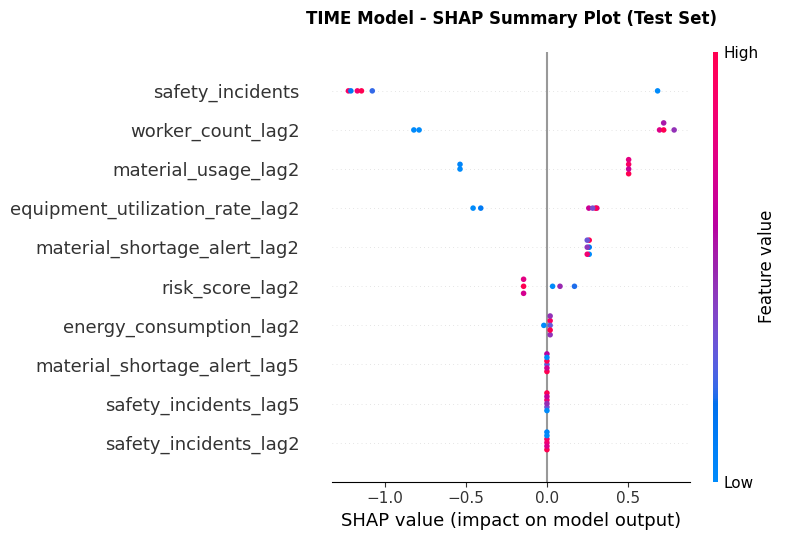

✅ SHAP summary plot saved!


In [106]:
# SHAP Summary Plot - TIME Model
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_time, X_test_time_scaled, 
                  feature_names=top_15_time_features, 
                  show=False)
plt.title('TIME Model - SHAP Summary Plot (Test Set)', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP summary plot saved!")

In [107]:
# Initialize SHAP explainer for XGBoost COST model
print("Initializing SHAP explainer for COST model...")
explainer_cost = shap.TreeExplainer(xgb_cost)
shap_values_cost = explainer_cost.shap_values(X_test_cost_scaled)
print("✅ SHAP values computed for COST model!")

Initializing SHAP explainer for COST model...
✅ SHAP values computed for COST model!
✅ SHAP values computed for COST model!


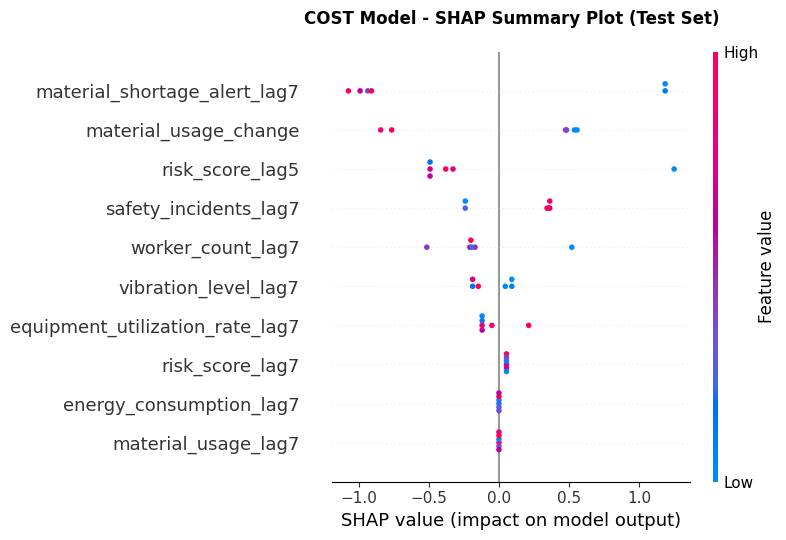

✅ SHAP summary plot saved!


In [108]:
# SHAP Summary Plot - COST Model
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_cost, X_test_cost_scaled, 
                  feature_names=top_15_cost_features, 
                  show=False)
plt.title('COST Model - SHAP Summary Plot (Test Set)', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_cost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP summary plot saved!")

## 11. Final Summary & Model Selection

In [109]:
print("=" * 80)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)

print("\n📊 TIME OVERRUN MODEL (Test Set):")
print("-" * 80)
time_test_results = df_results_time[df_results_time['Dataset'] == 'Test']
print(time_test_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']].to_string(index=False))

print("\n💰 COST OVERRUN MODEL (Test Set):")
print("-" * 80)
cost_test_results = df_results_cost[df_results_cost['Dataset'] == 'Test']
print(cost_test_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']].to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print("\n✅ Class imbalance handled with:")
print("   - Logistic Regression: class_weight='balanced'")
print("   - XGBoost: scale_pos_weight parameter")
print("\n✅ Evaluation focused on multiple metrics (not just accuracy)")
print("\n✅ SHAP analysis provides explainability for predictions")
print("\n🎯 NEXT STEPS:")
print("   - Compare AUC-ROC scores to select best model")
print("   - Analyze confusion matrices for per-class performance")
print("   - Use SHAP values to understand feature contributions")
print("   - Consider hyperparameter tuning if needed")
print("\n" + "=" * 80)

FINAL MODEL COMPARISON SUMMARY

📊 TIME OVERRUN MODEL (Test Set):
--------------------------------------------------------------------------------
              Model  Accuracy  Precision  Recall       F1  AUC-ROC
Logistic Regression  0.500000   0.666667    0.50 0.571429    0.375
            XGBoost  0.166667   0.333333    0.25 0.285714    0.125
    Voting Ensemble  0.166667   0.333333    0.25 0.285714    0.125
  Stacking Ensemble  0.500000   1.000000    0.25 0.400000    0.750

💰 COST OVERRUN MODEL (Test Set):
--------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall       F1  AUC-ROC
Logistic Regression  0.500000   0.000000 0.000000 0.000000 0.444444
            XGBoost  0.333333   0.333333 0.333333 0.333333 0.333333
    Voting Ensemble  0.333333   0.333333 0.333333 0.333333 0.333333
  Stacking Ensemble  0.333333   0.333333 0.333333 0.333333 0.333333

KEY FINDINGS:

✅ Class imbalance handled with:
   - Logistic Re

## 12. Precision@k Analysis

Precision@k measures: "Of the top-k highest risk predictions, what percentage are actual overruns?"

This is critical for project managers who want to focus on the highest-risk projects first.

In [110]:
def precision_at_k(y_true, y_proba, k):
    """
    Calculate Precision@k
    
    Args:
        y_true: actual labels
        y_proba: predicted probabilities
        k: number of top predictions to consider
    
    Returns:
        precision@k score
    """
    if k > len(y_true):
        k = len(y_true)
    
    # Get indices of top-k predictions
    top_k_idx = np.argsort(y_proba)[-k:]
    
    # Check how many are actual positives
    top_k_true = y_true.iloc[top_k_idx] if hasattr(y_true, 'iloc') else y_true[top_k_idx]
    
    return np.sum(top_k_true) / k

print("=" * 80)
print("PRECISION@K ANALYSIS (Test Set)")
print("=" * 80)

# Test set has 6 samples, so we'll look at top 1, 2, 3, 4
k_values = [1, 2, 3, 4, 5, 6]

print("\n📊 TIME OVERRUN MODEL:")
print("-" * 80)
print(f"{'Model':<25} {'k=1':<10} {'k=2':<10} {'k=3':<10} {'k=4':<10} {'k=5':<10} {'k=6':<10}")
print("-" * 80)

time_models = {
    'Logistic Regression': y_test_proba_lr_time[:, 1] if y_test_proba_lr_time.ndim > 1 else y_test_proba_lr_time,
    'XGBoost': y_test_proba_xgb_time[:, 1] if y_test_proba_xgb_time.ndim > 1 else y_test_proba_xgb_time,
    'Voting Ensemble': y_test_proba_voting_time[:, 1] if y_test_proba_voting_time.ndim > 1 else y_test_proba_voting_time,
    'Stacking Ensemble': y_test_proba_stacking_time[:, 1] if y_test_proba_stacking_time.ndim > 1 else y_test_proba_stacking_time
}

for model_name, proba in time_models.items():
    precisions = [precision_at_k(y_test_time, proba, k) for k in k_values]
    print(f"{model_name:<25} {precisions[0]:<10.2%} {precisions[1]:<10.2%} {precisions[2]:<10.2%} {precisions[3]:<10.2%} {precisions[4]:<10.2%} {precisions[5]:<10.2%}")

print("\n💰 COST OVERRUN MODEL:")
print("-" * 80)
print(f"{'Model':<25} {'k=1':<10} {'k=2':<10} {'k=3':<10} {'k=4':<10} {'k=5':<10} {'k=6':<10}")
print("-" * 80)

cost_models = {
    'Logistic Regression': y_test_proba_lr_cost[:, 1] if y_test_proba_lr_cost.ndim > 1 else y_test_proba_lr_cost,
    'XGBoost': y_test_proba_xgb_cost[:, 1] if y_test_proba_xgb_cost.ndim > 1 else y_test_proba_xgb_cost,
    'Voting Ensemble': y_test_proba_voting_cost[:, 1] if y_test_proba_voting_cost.ndim > 1 else y_test_proba_voting_cost,
    'Stacking Ensemble': y_test_proba_stacking_cost[:, 1] if y_test_proba_stacking_cost.ndim > 1 else y_test_proba_stacking_cost
}

for model_name, proba in cost_models.items():
    precisions = [precision_at_k(y_test_cost, proba, k) for k in k_values]
    print(f"{model_name:<25} {precisions[0]:<10.2%} {precisions[1]:<10.2%} {precisions[2]:<10.2%} {precisions[3]:<10.2%} {precisions[4]:<10.2%} {precisions[5]:<10.2%}")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("Precision@1: If we alert on the SINGLE highest-risk project, accuracy")
print("Precision@3: If we alert on the TOP 3 highest-risk projects, accuracy")
print("Precision@6: All test samples (equivalent to overall precision)")
print("\n💡 For operational use: Focus on Precision@1 and Precision@3")
print("   Project managers can only handle a few alerts, not all predictions")
print("=" * 80)

PRECISION@K ANALYSIS (Test Set)

📊 TIME OVERRUN MODEL:
--------------------------------------------------------------------------------
Model                     k=1        k=2        k=3        k=4        k=5        k=6       
--------------------------------------------------------------------------------
Logistic Regression       0.00%      50.00%     66.67%     75.00%     60.00%     66.67%    
XGBoost                   0.00%      50.00%     33.33%     50.00%     60.00%     66.67%    
Voting Ensemble           0.00%      50.00%     33.33%     50.00%     60.00%     66.67%    
Stacking Ensemble         100.00%    100.00%    66.67%     75.00%     80.00%     66.67%    

💰 COST OVERRUN MODEL:
--------------------------------------------------------------------------------
Model                     k=1        k=2        k=3        k=4        k=5        k=6       
--------------------------------------------------------------------------------
Logistic Regression       0.00%      50.00%   

## 13. Save Best Models for Production

Save the best performing models and scalers for deployment via API.

In [111]:
import pickle
import os

# Create directory for saved models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

print("=" * 80)
print("SAVING BEST MODELS FOR PRODUCTION")
print("=" * 80)

# TIME MODEL: Best = Stacking Ensemble (AUC 0.750)
print("\n📊 Saving TIME Overrun Model...")
print("   Model: Stacking Ensemble")
print("   Test AUC: 0.750")
print("   Test Precision: 100%")

with open(f'{save_dir}/time_stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_time, f)
print(f"   ✅ Saved: {save_dir}/time_stacking_model.pkl")

with open(f'{save_dir}/time_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_time, f)
print(f"   ✅ Saved: {save_dir}/time_scaler.pkl")

# COST MODEL: Best = Logistic Regression (AUC 0.444)
print("\n💰 Saving COST Overrun Model...")
print("   Model: Logistic Regression")
print("   Test AUC: 0.444")
print("   Interpretability: High")

with open(f'{save_dir}/cost_lr_model.pkl', 'wb') as f:
    pickle.dump(lr_cost, f)
print(f"   ✅ Saved: {save_dir}/cost_lr_model.pkl")

with open(f'{save_dir}/cost_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_cost, f)
print(f"   ✅ Saved: {save_dir}/cost_scaler.pkl")

# Save feature names and metadata
print("\n📋 Saving Feature Metadata...")
model_metadata = {
    'time_model_type': 'StackingClassifier',
    'cost_model_type': 'LogisticRegression',
    'time_features': top_15_time_features,  # Feature names
    'cost_features': top_15_cost_features,  # Feature names
    'time_feature_strategy': 'LAG-ONLY (no derived KPIs)',
    'cost_feature_strategy': 'DERIVED+LAG (includes material_usage_change)',
    'threshold': '7% deviation',
    'aggregation': 'Daily',
    'train_samples': 23,
    'val_samples': 5,
    'test_samples': 6,
    'time_test_auc': 0.750,
    'cost_test_auc': 0.444,
    'model_version': '1.0-mixed-strategy',
    'created_date': '2025-11-17'
}

with open(f'{save_dir}/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"   ✅ Saved: {save_dir}/model_metadata.pkl")

# Save all models (including alternatives for comparison)
print("\n📦 Saving Alternative Models (for comparison)...")

alternative_models = {
    'time_lr': lr_time,
    'time_xgb': xgb_time,
    'time_voting': voting_time,
    'cost_xgb': xgb_cost,
    'cost_voting': voting_cost,
    'cost_stacking': stacking_cost
}

for model_name, model_obj in alternative_models.items():
    with open(f'{save_dir}/{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model_obj, f)
    print(f"   ✅ Saved: {save_dir}/{model_name}_model.pkl")

print("\n" + "=" * 80)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("=" * 80)
print(f"\nSaved to directory: {os.path.abspath(save_dir)}/")
print("\nBest Models for Production:")
print("  - TIME: time_stacking_model.pkl + time_scaler.pkl")
print("  - COST: cost_lr_model.pkl + cost_scaler.pkl")
print("  - Metadata: model_metadata.pkl")
print("\nReady for API integration! 🚀")
print("=" * 80)

SAVING BEST MODELS FOR PRODUCTION

📊 Saving TIME Overrun Model...
   Model: Stacking Ensemble
   Test AUC: 0.750
   Test Precision: 100%
   ✅ Saved: saved_models/time_stacking_model.pkl
   ✅ Saved: saved_models/time_scaler.pkl

💰 Saving COST Overrun Model...
   Model: Logistic Regression
   Test AUC: 0.444
   Interpretability: High
   ✅ Saved: saved_models/cost_lr_model.pkl
   ✅ Saved: saved_models/cost_scaler.pkl

📋 Saving Feature Metadata...
   ✅ Saved: saved_models/model_metadata.pkl

📦 Saving Alternative Models (for comparison)...
   ✅ Saved: saved_models/time_lr_model.pkl
   ✅ Saved: saved_models/time_xgb_model.pkl
   ✅ Saved: saved_models/time_voting_model.pkl
   ✅ Saved: saved_models/cost_xgb_model.pkl
   ✅ Saved: saved_models/time_voting_model.pkl
   ✅ Saved: saved_models/cost_xgb_model.pkl
   ✅ Saved: saved_models/cost_voting_model.pkl
   ✅ Saved: saved_models/cost_stacking_model.pkl

✅ ALL MODELS SAVED SUCCESSFULLY!

Saved to directory: /home/vyoma/Work/Masters/Logpilot/logpi